In [1]:
import os
os.chdir("../../..")
import jax
jax.devices()

[CpuDevice(id=0)]

In [2]:
from scripts.nj.neurosci import *
import scripts.nj.graph_to_arrays as ga

## Получаем данные

In [3]:
res = ga.load_jax_context("Datasets/Generated/gml/test_graph_20n_optimized_params.npz")

Загрузка контекста из: Datasets/Generated/gml/test_graph_20n_optimized_params.npz
   Загружено: 2 групп, 3 массивов ребер, 0 массивов признаков.
Контекст симуляции успешно собран из загруженных данных.


In [4]:
stom = jnp.array(res['stom'])

In [5]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

In [6]:
stom

Array([[10191936,      132],
       [11531426,     1144],
       [12132809,     1481],
       [12927058,     1828],
       [17855652,     5258],
       [ 1805496,     5361],
       [19255911,     5940],
       [ 2662497,     9022],
       [ 4505350,    10191],
       [ 4982132,    10926],
       [ 5018684,    11025],
       [ 7056349,    11455],
       [ 7810915,    11843],
       [ 7843014,    12032],
       [ 8108327,    12470],
       [ 8250193,    12546],
       [ 8824003,    13248],
       [ 8939282,    13386],
       [ 8981142,    13448],
       [ 9011915,    13726]], dtype=int32)

## Определяем структуру симуляции

In [20]:
a, b = '7055857', '1805418'
ind_to_stim = stom[5][1]
ind_to_stim1 = stom[11][1]
def get_my_pipeline(constants, dt = 0.1):

    cable_m = res['edges_cable_to_cable'].T
    pre_syn = res['edges_cable_to_alpha'].T
    post_syn = res['edges_cable_to_alpha'].T
    
    r = jnp.array(res['diam'])/2
    S = np.pi * r**2

    Rm = 10000 # какое у нас Rm?

    L = jnp.array(res['L'])
    ra = jnp.array(res['Ra']) # аксиональное
    rm = Rm/(np.pi * r) # трансмембранное

    lambda_squared = rm/ra
    tau_hh = ra*rm
    #constants['C'] = constants['C']*tau_hh
    

    HH = get_HH_pipeline(**constants) # получаем функцию для HH
    cable = laplace_at_graph_symetric(cable_m, 'V', scaling = lambda_squared) # получаем функцию для динамики кабелей
    alphaP = get_alpha_synapce_pipeline(pre_syn, post_syn, **constants)
    
    @jax.jit
    def state_transformed(state):
        s, ds = to_diff(state) # создает ds той же формы что и state, но заполненный нулями
        s, ds = alphaP(s, ds)
        s, ds = HH(s, ds) # вставляет HH каналы
        s, ds = cable(s, ds) # соединяет сегменты
        ds['V'] += ds['V'].at[ind_to_stim].add(0.7*(s['time'] > 10.0)*(s['time'] < 60.0))
        #ds['V'] += ds['V'].at[ind_to_stim1].add(0.7*(s['time'] > 10.0)*(s['time'] < 60.0))
        return s, ds

    integrate = get_runge_kutta_step(state_transformed, dt) # получаем функцию для интегрирования
    @jax.jit
    def my_pipeline(state):
        s = integrate(state) # интегрируем
        return s
    return my_pipeline


### Начальные значения и константы


In [21]:
num_nodes_hh = res['num_nodes']['cable']
num_synapces = res['num_nodes']['alpha']
total_nodes = num_nodes_hh + num_synapces

initials = {
    "V":jnp.ones((num_nodes_hh, ), jnp.float32)*-65.0,
    "m":jnp.ones((num_nodes_hh, ), jnp.float32)*0.0220,
    'n':jnp.ones((num_nodes_hh, ), jnp.float32)*0.0773,
    'h':jnp.ones((num_nodes_hh, ), jnp.float32)*0.9840,
    'alpha':jnp.ones((num_nodes_hh, 2), jnp.float32)*0.1,
    "time":0.0
}

consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54.4,   # Равновесный потенциал утечки (мВ)
    "gNa": 120.0,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": 36.0,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": 0.3,     # Проводимость утечки (мСм/см^2),
    "tau":1.0,
    'E_rev':1.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':40.0,
    'synaptic_weights':0.01,
    'G_max':1.0
}


new_consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": jnp.array(res['el_hh']),   # Равновесный потенциал утечки (мВ)
    "gNa": jnp.array(res['gnabar_hh']),  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": jnp.array(res['gkbar_hh']),    # Максимальная проводимость K+ (мСм/см^2)
    "gL": jnp.array(res['gl_hh']),     # Проводимость утечки (мСм/см^2),
    "tau":1.25,
    'E_rev':0.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':0.5,
    'synaptic_weights':0.5,
    'G_max':1.0
}

In [22]:
res['gnabar_hh'].shape

(14409,)

In [30]:
my_pipeline = get_my_pipeline(new_consts, 0.001)

In [31]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

## Запуск симуляции

In [35]:
@jax.jit
def output_transform(state):
    return state['time'], state['V'].at[stom[:, 1]].get()

jsim = simulation(initials, my_pipeline, 1000, output_transform)
H = jax.block_until_ready(jsim.run(40))

In [33]:
H

(Array([0.9999907, 2.0000374, 2.999965 ], dtype=float32, weak_type=True),
 Array([[-64.6704  , -64.924446, -64.87921 , -64.42905 , -64.82691 ,
         -64.74711 , -64.876015, -64.79134 , -64.40067 , -64.915596,
         -64.723404, -64.85898 , -64.71217 , -64.77692 , -64.75643 ,
         -64.87075 , -64.736244, -64.874985, -64.88056 , -64.77929 ],
        [-64.479515, -64.88316 , -64.81598 , -64.08301 , -64.73905 ,
         -64.583595, -64.80455 , -64.668076, -64.02191 , -64.8709  ,
         -64.55804 , -64.77557 , -64.53871 , -64.638306, -64.60554 ,
         -64.793365, -64.56958 , -64.814865, -64.816414, -64.65784 ],
        [-64.4211  , -64.87877 , -64.80425 , -63.95301 , -64.74363 ,
         -64.50655 , -64.793175, -64.62376 , -63.84362 , -64.862656,
         -64.49282 , -64.74304 , -64.47887 , -64.57729 , -64.54145 ,
         -64.76647 , -64.49968 , -64.807274, -64.798485, -64.621864]],      dtype=float32))

## Построение графиков

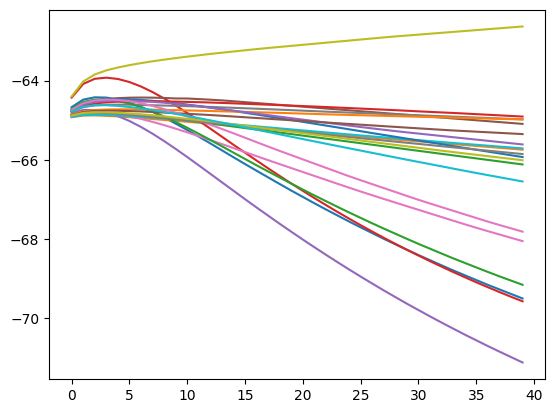

In [36]:
import matplotlib.pyplot as plt
t, v = H
t, v = np.array(t), np.array(v)
plt.plot(v)
plt.show()